# Natural Language Processing : Twitter Sentiment Analysis

## Import necessary libraries

In [1]:
#import libraries below
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt                                           
import seaborn as sns                                                    

from collections import Counter                                                

import re, string, unicodedata                                                  
import contractions                                                            
from bs4 import BeautifulSoup                                                   

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator                 
import nltk                                                                     
from nltk.corpus import stopwords                                             
from nltk.tokenize import word_tokenize, sent_tokenize                          
from nltk.stem.wordnet import WordNetLemmatizer                                 
from nltk.stem.porter import PorterStemmer                                      
        
from sklearn.feature_extraction.text import TfidfVectorizer                     

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report                               
from sklearn.model_selection import cross_val_score 

## Import Data

In [55]:
df = pd.read_csv('Tweets.csv')

In [3]:
df.shape

(14640, 15)

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## EDA

In [57]:
#summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


In [66]:
# show number of tweets by sentiment
df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

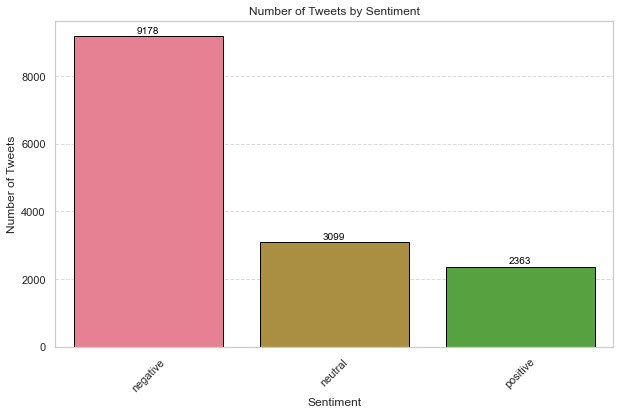

In [98]:
sentiment_counts = df['airline_sentiment'].value_counts()

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", palette="husl")

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, edgecolor='black')

for i, count in enumerate(sentiment_counts.values):
    plt.text(i, count + 30, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets by Sentiment')

plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [68]:
#no. of tweets by airline
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

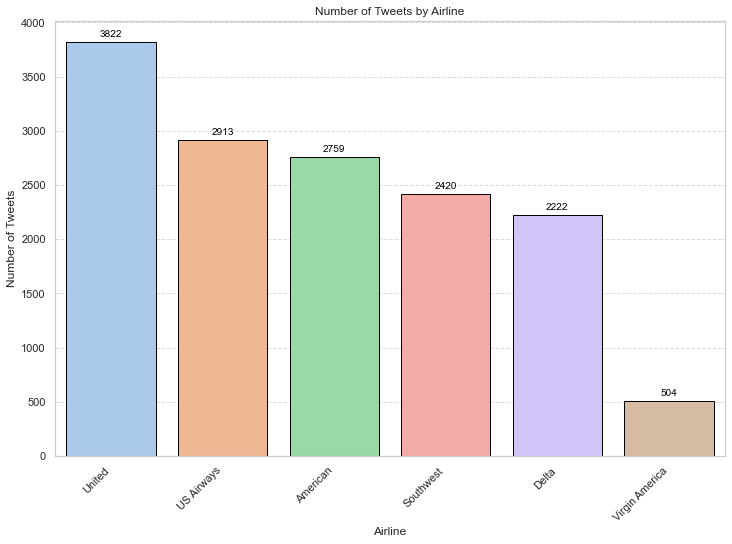

In [100]:
airline_counts = df['airline'].value_counts()

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid", palette="pastel")

sns.barplot(x=airline_counts.index, y=airline_counts.values, edgecolor='black')

for i, count in enumerate(airline_counts.values):
    plt.text(i, count + 30, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets by Airline')

plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [74]:
#No. of tweets by sentiment per airline
sentiment_per_airline = df.groupby('airline')['airline_sentiment'].value_counts()
sentiment_per_airline

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: airline_sentiment, dtype: int64

<Figure size 864x576 with 0 Axes>

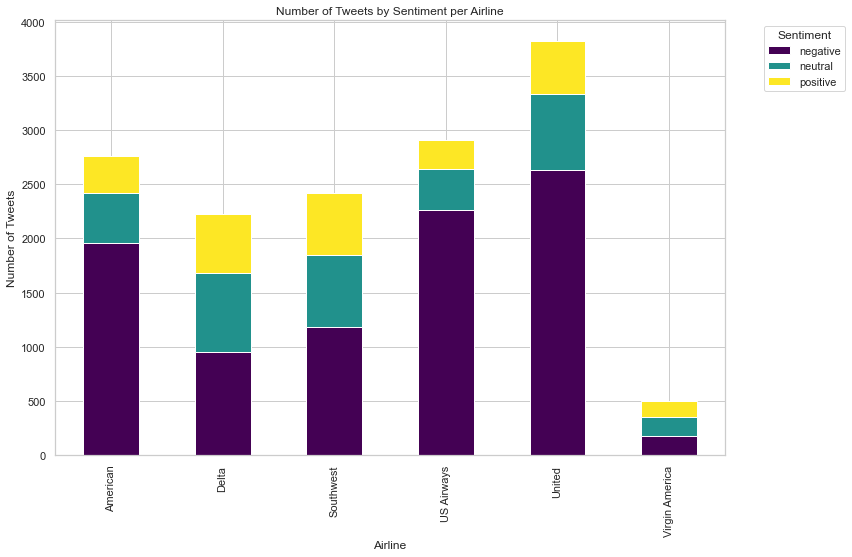

In [76]:
sentiment_per_airline_unstacked = sentiment_per_airline.unstack()

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sentiment_per_airline_unstacked.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))

plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets by Sentiment per Airline')

plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [91]:
#Word Cloud for negative and positive sentiment
positive_tweets = df[df['airline_sentiment'] == 'positive']
negative_tweets = df[df['airline_sentiment'] == 'negative']

# Function to generate and plot a word cloud
def generate_wordcloud(text, title):
    words = ' '.join(text['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_word)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

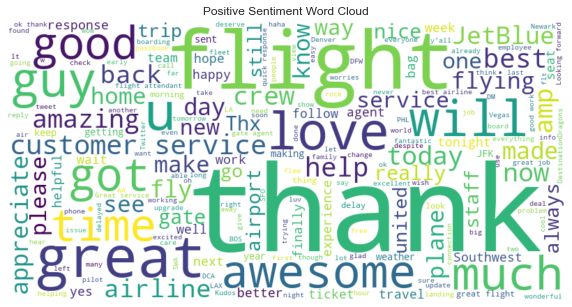

In [92]:
generate_wordcloud(positive_tweets, 'Positive Sentiment Word Cloud')

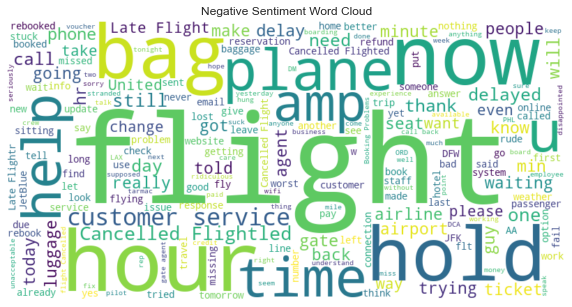

In [93]:
generate_wordcloud(negative_tweets, 'Negative Sentiment Word Cloud')

Flight is a very common word in both positive and negative tweets, indicating that this word will likely not contribute to a classification model

## Data Cleaning

In [6]:
# convert all columns with dtype object into category to save memory
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [7]:
#drop all columns that are not needed
drop_columns = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 
                'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 
                'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
df = df.drop(columns = drop_columns)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   airline_sentiment  14640 non-null  category
 1   text               14640 non-null  category
dtypes: category(2)
memory usage: 671.9 KB


In [9]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Data Preprocessing

In [10]:
import emoji

In [11]:
#remove the numericals present in the tweets
def remove_numbers(tweet):
    tweet = re.sub(r'\d+', '', tweet)
    return tweet

#remove urls
def remove_url(tweet):
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(@[^\s]+))', '', tweet) 
    return tweet

# remove the mentions in the tweets
def remove_mention(tweet):
    if isinstance(tweet, str):  # Check if the input is a string
        tweet = re.sub(r'@\w+', '', tweet)
    return tweet

#remove emoji
def remove_emojis(tweet):
    return ''.join(c for c in tweet if not emoji.is_emoji(c))

def clean_text(tweet):
    tweet = remove_url(tweet)
    tweet = remove_mention(tweet)
    tweet = remove_numbers(tweet)
    tweet = remove_emojis(tweet)
    return tweet

df.text = df.text.apply(lambda x: clean_text(x))

In [12]:
df.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you've added commercials to the experien...
2,neutral,I didn't today... Must mean I need to take an...
3,negative,"it's really aggressive to blast obnoxious ""en..."
4,negative,and it's a really big bad thing about it


In [13]:
#tokenization
df.text = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [14]:
df.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, 've, added, commercials, to, the, ..."
2,neutral,"[I, did, n't, today, ..., Must, mean, I, need,..."
3,negative,"[it, 's, really, aggressive, to, blast, obnoxi..."
4,negative,"[and, it, 's, a, really, big, bad, thing, abou..."


In [15]:
from nltk import pos_tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
stopwords = stopwords.words('english')
custom_remove_list = ['flight', 'airline']
stopwords = list(set(stopwords)) + custom_remove_list
lemmatizer = WordNetLemmatizer()

#remove non ASCII characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# remove the punctuations
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# remove the stop words
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
        pos = pos_tag([word])
        new_words.append(lemmatizer.lemmatize(word, pos = get_simple_pos(pos[0][1])))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df.text = df.apply(lambda row: normalize(row['text']), axis=1)

In [17]:
df.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercial experience tacky
2,neutral,nt today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing


## Recurring Neural Network

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder

In [19]:
X = df.text
y = df.airline_sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [20]:
# Convert labels to numerical values
le = LabelEncoder()
y_train_label = le.fit_transform(y_train)
y_test_label = le.fit_transform(y_test)

In [21]:
# Tokenize
max_words = 4000
max_len = 1000

tokenizer = Tokenizer(num_words=max_words, char_level=False)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

len(X_train_seq)

10980

In [22]:
#pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print('Shape of data tensor:', X_train_pad.shape)
print('Shape of data test tensor:', X_test_pad.shape)
print(type(X_train))

Shape of data tensor: (10980, 1000)
Shape of data test tensor: (3660, 1000)
<class 'pandas.core.series.Series'>


### Model Creation

In [23]:
from keras import backend
import tensorflow as tf
backend.clear_session()

# set the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, SpatialDropout1D

def create_model1(maxlen, num_words, num_categories):
    
    model = Sequential()
    
    model.add(Embedding(num_words, output_dim=64, input_length=maxlen, trainable=True))
    model.add(SpatialDropout1D(0.2))
    
    model.add(Bidirectional(LSTM(64)))
    
    model.add(Dropout(0.3))
    
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(num_categories, activation='softmax'))
              
    model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

    model.summary()
    return model

In [30]:
model1 = create_model1(max_len, max_words, df.airline_sentiment.nunique())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 64)          256000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 1000, 64)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                      

In [32]:
# Fit the model to the reshaped and padded training data
history1 = model1.fit(X_train_pad, y_train_label, epochs=5, validation_split=0.25)

Epoch 1/5
258/258 [==============================] - 167s 635ms/step - loss: 0.9787 - accuracy: 0.5825 - val_loss: 0.8166 - val_accuracy: 0.6240
Epoch 2/5
258/258 [==============================] - 129s 502ms/step - loss: 0.6310 - accuracy: 0.7388 - val_loss: 0.6294 - val_accuracy: 0.7443
Epoch 3/5
258/258 [==============================] - 135s 522ms/step - loss: 0.5102 - accuracy: 0.7984 - val_loss: 0.6142 - val_accuracy: 0.7588
Epoch 4/5
258/258 [==============================] - 135s 524ms/step - loss: 0.4159 - accuracy: 0.8344 - val_loss: 0.5992 - val_accuracy: 0.7668
Epoch 5/5
258/258 [==============================] - 172s 667ms/step - loss: 0.3616 - accuracy: 0.8622 - val_loss: 0.6548 - val_accuracy: 0.7552


### Model Evaluation on Training Data

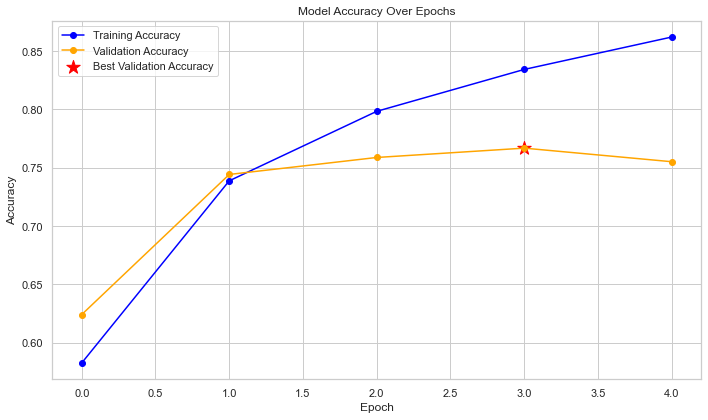

In [95]:
# Plotting the model accuracy
plt.figure(figsize=(10, 6))
plt.plot(history1.history['accuracy'], label='Training Accuracy', color='blue', marker='o', linestyle='-')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o', linestyle='-')

best_val_acc_epoch = history1.history['val_accuracy'].index(max(history1.history['val_accuracy']))
plt.scatter(best_val_acc_epoch, max(history1.history['val_accuracy']), color='red', marker='*', s=200, label='Best Validation Accuracy')

plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Model Evaluation on Testing Data

In [37]:
accuracy = model1.evaluate(X_test_pad, y_test_label, verbose=2)

115/115 - 21s - loss: 0.6674 - accuracy: 0.7549 - 21s/epoch - 183ms/step


In [38]:
#creating a dictionary to map model predictions to each sentiment
class_dict = {0:'negative',
 1:'neutral',
 2:'positive'}

In [40]:
#making predictions on the test data
y_pred_test = model1.predict(X_test_pad)

#converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

115/115 [==============================] - 21s 176ms/step


In [41]:
#creating a dataframe of model predictions
df = pd.DataFrame({"Labels":y_pred_test_classes})

#replacing predictions with sentiments
label_df = df.replace({"Labels":class_dict})

#converting dataframe to array
y_pred_test_classes = label_df.to_numpy()

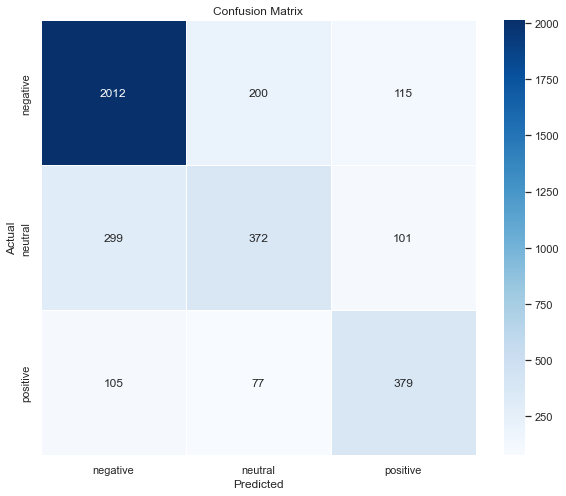

In [94]:
from sklearn.metrics import confusion_matrix, classification_report
#plotting the heatmap using confusion matrix
class_labels = list(class_dict.values())

cm_rnn = confusion_matrix(y_test, y_pred_test_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rnn, annot=True, fmt='.0f', cmap='Blues', linewidths=.5, square=True, xticklabels=class_labels, yticklabels=class_labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

plt.show()

## Classification Report

In [50]:
# provide the classification report on the RNN model
print("Recurring Neural Network (RNN) model")
print(" ")
print(classification_report(y_test, y_pred_test_classes))

Recurring Neural Network (RNN) model
 
              precision    recall  f1-score   support

    negative       0.83      0.86      0.85      2327
     neutral       0.57      0.48      0.52       772
    positive       0.64      0.68      0.66       561

    accuracy                           0.75      3660
   macro avg       0.68      0.67      0.68      3660
weighted avg       0.75      0.75      0.75      3660

